In [21]:
# Fast style transfer - to check the complete style transfer later

import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))


TF Version:  2.4.1
TF-Hub version:  0.11.0
Eager mode enabled:  True
GPU available:  []


In [35]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


@functools.lru_cache(maxsize=None)
def load_local_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  #image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_url).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

In [32]:
#outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
#stylized_image = outputs[0]


In [42]:
# for now, one content and one style image

class ImageStyle():
    # intant... the model with the output and style image size, and the
    # trained neural netwrok (hub_handle), by default: arbitrary-image-stylization-v1-256
    # returs self
    def __init__(self, output_image_size = 384,
                 style_image_size = (256, 256),
                hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'):
        self.content_image = None
        self.style_image = None
        self.stylized_image = None
        self.content_image_size = (output_image_size, output_image_size)
        self.output_image_size = output_image_size
        self.style_image_size = style_image_size
        self.hub_module = hub.load(hub_handle) # check if we can store it
        return None

    # loads the image given in content_url and style_url, return self
    def load_images(self, content_image_url, style_image_url):
        self.content_image = load_image(content_image_url, self.content_image_size)
        self.style_image = tf.nn.avg_pool(load_image(style_image_url, self.style_image_size),
                                          ksize=[3,3], strides=[1,1], padding='SAME')
        return self

    # loads the image given in content_url and style_url, return self
    def load_local_images(self, content_image_url, style_image_url):
        self.content_image = load_local_image(content_image_url, self.content_image_size)
        self.style_image = tf.nn.avg_pool(load_local_image(style_image_url, self.style_image_size),
                                          ksize=[3,3], strides=[1,1], padding='SAME')
        return self

    # stylize the image
    def stylize(self):
        self.stylized_image = hub_module(self.content_image,
                                         self.style_image)[0] # 0, as more images can be done at the same time

    # prints the originals (plt.imshow)
    def show_originals(self):
        if (self.content_image != None) and (self.style_image != None):
            show_n([self.content_image, self.style_image], ['Content image', 'Style image'])
        return None

    # prints all 3 images (plt.imshow)
    def show_all_images(self):
        if self.stylized_image != None:
            show_n([self.content_image, self.style_image, self.stylized_image],
                   titles=['Original content image', 'Style image', 'Stylized image'])
        return None

    def show_stylized_image(self):
        if self.stylized_image != None:
            show_n([self.stylized_image],
                   titles=['Stylized image'])
        return None

    # returns the picture as array
    def get_pic(self):
        return self.stylized_image

    # saves the last
    def save_jpgs(self, filename = 'output.jpg'):
        # write to jpg
        plt.imshow(self.stylized_image[0], aspect='equal')
        plt.axis('off')
        plt.savefig(filename)
        return None

In [39]:
content_image_url = '/Users/ger/Desktop/marina.jpeg'  # @param {type:"string"}
style_image_url = '/Users/ger/Desktop/marina_style.jpeg'  # @param {type:"string"}
ist = ImageStyle() # inst
ist.load_local_images(content_image_url,style_image_url)
ist.stylize() # style

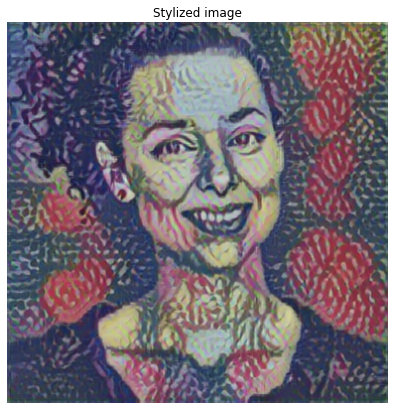

<Figure size 432x288 with 0 Axes>

In [44]:
ist.show_stylized_image()
plt.savefig('/Users/ger/Desktop/marina_mix.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'data/marina.jpg'

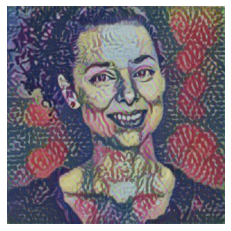

In [43]:
ist.save_jpgs('marina.jpg')

In [142]:
style2_url='https://images.freeimages.com/images/large-previews/bb6/stairs-in-the-forest-1235063.jpg'
pic_url='https://upload.wikimedia.org/wikipedia/commons/0/02/1980_USSR_stamp_Olympic_mascot.jpg'